In [2]:
import scanpy as sc
import scvelo as scv

data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()

In [43]:
set(label)

{'Alpha',
 'Beta',
 'Delta',
 'Ductal',
 'Epsilon',
 'Ngn3 high EP',
 'Ngn3 low EP',
 'Pre-endocrine'}

In [3]:
from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib


In [4]:
type(data)

anndata._core.anndata.AnnData

In [5]:
data.shape

(3696, 27998)

In [6]:
# Count each cell types
from collections import Counter

print(Counter(label))

Counter({'Ductal': 916, 'Ngn3 high EP': 642, 'Pre-endocrine': 592, 'Beta': 591, 'Alpha': 481, 'Ngn3 low EP': 262, 'Epsilon': 142, 'Delta': 70})


## Normalization

In [7]:
# CPM (do not do CPM normalization)
# sc.pp.normalize_total(data, target_sum=1e6)

# log1p: log(x+1)
sc.pp.log1p(data)

In [8]:
# Binary classification of CD4 CTL
alpha_label = [1 if x == 'Alpha' else 0 for x in label]

# create index for CD4 CTL
alpha_indices = [idx for idx, label in enumerate(alpha_label) if label == 1]


## Get features for Alpha cells (general)

In [9]:
pvl = ad.get_prevalence(data.X, alpha_indices)
res = ad.ADlasso2(lmbd=1e-5, echo=True)
res.fit(data.X, alpha_label, pvl)

Getting prevalance
QWL-QN convergence
QWL-QN convergence
minimum epoch =  2 ; minimum lost =  0.46201518177986145 ; diff weight =  1.6863794371602125e-05


In [10]:
print('median of selected prevalence :',np.median([pvl[i]  for i, w in enumerate(res.feature_set) if w != 0]))
print('total selected feature :',np.sum(res.feature_set))

median of selected prevalence : 0.10187110187110188
total selected feature : 12143


In [12]:
res.loss_

0.46201518177986145

## autoscale breakdown

In [25]:
# autoscale breakdown
X_norm = data.X
Y = alpha_label
device = 'cpu'
training_echo=False
max_iter=100
tol=1e-4
alpha=0.001
gamma=0.1

class_content = np.unique(Y)
if len(class_content) != 2:
    raise ValueError("This solver needs samples of at only 2 classe.")

n_samples_i, n_features_i = X_norm.shape
n_samples_r, n_features_r = X_norm.shape    
if n_samples_i != n_samples_r:
    raise ValueError("Found input data with inconsistent numbers of samples with raw data: %r" % [n_samples_i, n_samples_r])
    
if n_features_i != n_features_r:
    raise ValueError("Found input data with inconsistent numbers of features with raw data: %r" % [n_features_i, n_features_r])

if len(Y) != n_samples_i:
    # raise ValueError("Found input label with inconsistent numbers of samples: %r" % [self.n_samples, len(Y)])
    raise ValueError("Found input label with inconsistent numbers of samples: %r" % [n_samples_i, len(Y)])
    
if device == 'cuda':
    if not torch.cuda.is_available():
        print("your GPU is not available, ADlasso is running with CPU.")
        device= 'cpu'


In [27]:

y = np.array([0 if yi == class_content[0] else 1 for yi in Y])
# Modify sample_index for prevalence calculation
celltype_indices = [idx for idx, label in enumerate(Y) if label == 1]
# pvl = get_prevalence(X_norm, np.arange(X_norm.shape[0]))
pvl = ad.get_prevalence(X_norm, celltype_indices)

exam_range = [1/(10**i) for i in np.arange(10,-1,-1)]  # 1e-10 to 1e-1
select_number = []
for lmbd in exam_range:
    print('Lambda:', lmbd)
    exam_res = ad.ADlasso2(lmbd=lmbd, device=device, echo=training_echo,
                                max_iter=max_iter, tol=tol, alpha=alpha, gamma=gamma)
    exam_res.fit(X_norm, y, pvl)
    select_number.append(np.sum(exam_res.feature_set))
upper  = np.nan
for i in range(len(exam_range)):
    if np.isnan(upper):
        if select_number[i] < n_features_i*0.9:
            upper  = exam_range[i]
    if select_number[i] < 10:
        lower  = exam_range[i]
        break

Getting prevalance
isspmatrix_csr prevalence
Lambda: 1e-10
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1e-09
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1e-08
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1e-07
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1e-06
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1e-05
iter: 0
iter: 1
QWL-QN convergence
Lambda: 0.0001
iter: 0
iter: 1
QWL-QN convergence
Lambda: 0.001
iter: 0
iter: 1
QWL-QN convergence
Lambda: 0.01
iter: 0
iter: 1
QWL-QN convergence
Lambda: 0.1
iter: 0
iter: 1
QWL-QN convergence
Lambda: 1.0
iter: 0
iter: 1
QWL-QN convergence


## Auto scale

In [13]:
log_lmbd_range = ad.auto_scale(data.X, alpha_label, step=50)

lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)


Getting prevalance
Lambda: 1e-10
QWL-QN convergence
Lambda: 1e-09
QWL-QN convergence
Lambda: 1e-08
QWL-QN convergence
Lambda: 1e-07
QWL-QN convergence
Lambda: 1e-06
QWL-QN convergence
Lambda: 1e-05
QWL-QN convergence
Lambda: 0.0001
QWL-QN convergence
Lambda: 0.001
QWL-QN convergence
Lambda: 0.01
QWL-QN convergence
Lambda: 0.1
QWL-QN convergence
Lambda: 1.0
QWL-QN convergence
[1.00000000e-10 1.59985872e-10 2.55954792e-10 4.09491506e-10
 6.55128557e-10 1.04811313e-09 1.67683294e-09 2.68269580e-09
 4.29193426e-09 6.86648845e-09 1.09854114e-08 1.75751062e-08
 2.81176870e-08 4.49843267e-08 7.19685673e-08 1.15139540e-07
 1.84206997e-07 2.94705170e-07 4.71486636e-07 7.54312006e-07
 1.20679264e-06 1.93069773e-06 3.08884360e-06 4.94171336e-06
 7.90604321e-06 1.26485522e-05 2.02358965e-05 3.23745754e-05
 5.17947468e-05 8.28642773e-05 1.32571137e-04 2.12095089e-04
 3.39322177e-04 5.42867544e-04 8.68511374e-04 1.38949549e-03
 2.22299648e-03 3.55648031e-03 5.68986603e-03 9.10298178e-03
 1.45634848e

In [34]:
lmbd_range

NameError: name 'lmbd_range' is not defined

## Lambda tuning

In [15]:
result_dict = ad.lambda_tuning_evan(data.X, alpha_label, lmbd_range)

Getting prevalance
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 9.999999999999996e-11, cost : 0.039 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 1.599858719606056e-10, cost : 0.039 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 2.5595479226995397e-10, cost : 0.04 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 4.0949150623804276e-10, cost : 0.036 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 6.551285568595507e-10, cost : 0.039 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 1.0481131341546845e-09, cost : 0.036 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 1.6768329368110049e-09, cost : 0.039 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 2.6826957952797275e-09, cost : 0.037 min
Getting prevalance
Getting prevalance
QWL-QN convergence
lambda is : 4.291934260128777e-09, cost : 0.038 

In [20]:
result_dict

{'Percentage': array([0.50903636, 0.50717908, 0.50928638, 0.51107222, 0.50885778,
        0.50871491, 0.5038217 , 0.5074291 , 0.50889349, 0.51085792,
        0.50978641, 0.50375027, 0.51053647, 0.5078577 , 0.51035788,
        0.50760769, 0.50903636, 0.50500036, 0.49078506, 0.48549896,
        0.47771269, 0.46853347, 0.45942567, 0.45038931, 0.4376384 ,
        0.42606615, 0.41520823, 0.40338596, 0.39120651, 0.3775984 ,
        0.36238303, 0.34584613, 0.32802343, 0.30752197, 0.28566326,
        0.261983  , 0.23690978, 0.20905065, 0.1817987 , 0.15311808,
        0.12818773, 0.10261447, 0.08079149, 0.06121866, 0.04436031,
        0.0316094 , 0.01953711, 0.01092935, 0.00546468, 0.00207158]),
 'Prevalence': array([0.07276507, 0.07276507, 0.07276507, 0.07276507, 0.07276507,
        0.07276507, 0.07484407, 0.07276507, 0.07276507, 0.07276507,
        0.07276507, 0.07484407, 0.07276507, 0.07276507, 0.07276507,
        0.07276507, 0.07276507, 0.07484407, 0.07900208, 0.08108108,
        0.08523909

In [17]:
os.chdir('./LmbdTuning/tuning alpha/')

In [19]:
# Export result dict as a file
import json

output = dict()
for key in result_dict.keys():
    output[key] = result_dict[key].tolist()

with open('alpha_tuning.json', 'w') as f:
    json.dump(output, f)
    

## Visualization

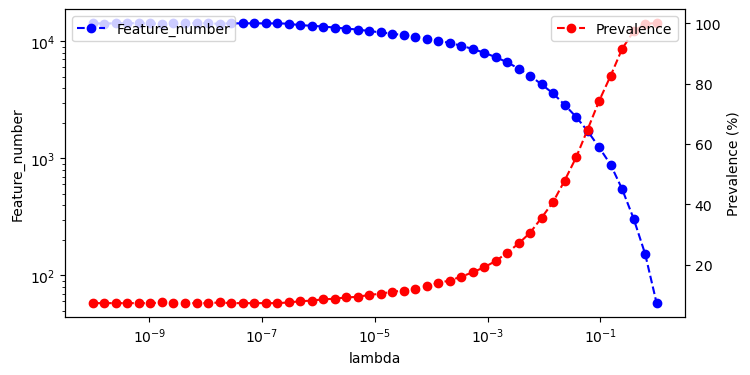

In [21]:
Fig = ad.lambda_tuning_viz(result_dict, 'Feature_number')

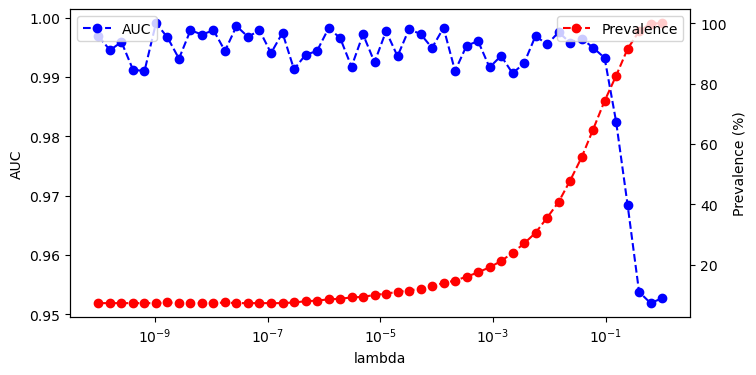

In [22]:
Fig = ad.lambda_tuning_viz(result_dict, 'AUC')

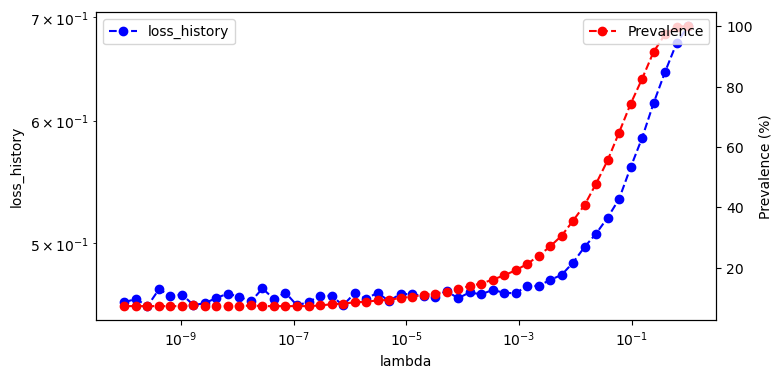

In [23]:
Fig = ad.lambda_tuning_viz(result_dict, 'loss_history')

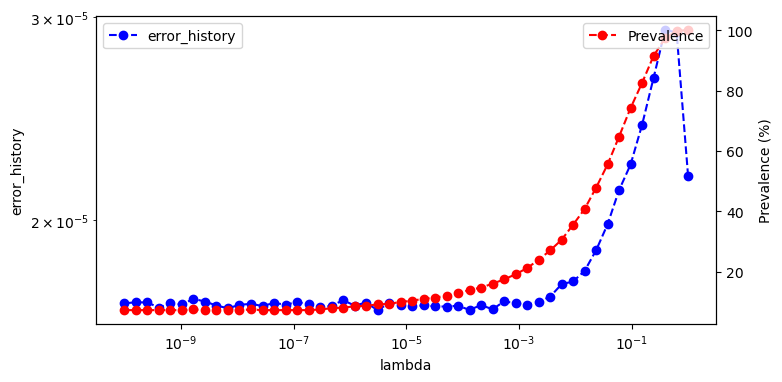

In [24]:
Fig = ad.lambda_tuning_viz(result_dict, 'error_history')

In [25]:
result_dict.keys()

dict_keys(['Percentage', 'Prevalence', 'Train_prevalence', 'Train_prevalence_global', 'Feature_number', 'AUC', 'AUPR', 'MCC', 'loss_history', 'error_history', 'log_lambda_range'])

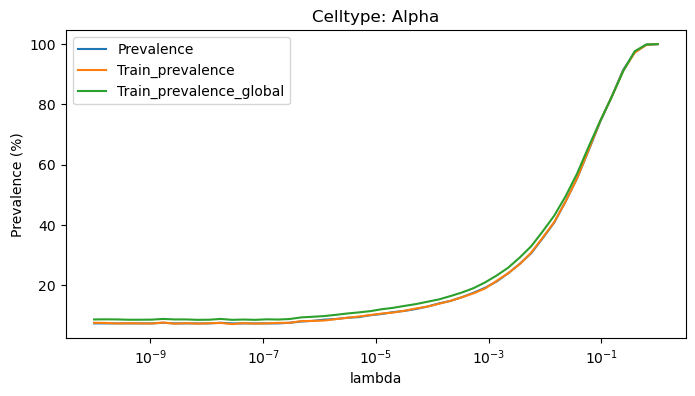

In [26]:
x = np.exp(result_dict['log_lambda_range'])
y1 = result_dict['Prevalence']
y2 = result_dict['Train_prevalence']
y3 = result_dict['Train_prevalence_global']

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, [100*y for y in y1], label='Prevalence')
ax.plot(x, [100*y for y in y2], label='Train_prevalence')
ax.plot(x, [100*y for y in y3], label='Train_prevalence_global')
ax.set_xlabel('lambda')
ax.set_ylabel('Prevalence (%)')
ax.set_xscale('log')
ax.set_title('Celltype: Alpha')
ax.legend()
plt.show()

## Lambda decision
Determine the optimal lambda value based on the inflection point of the BCE loss curve

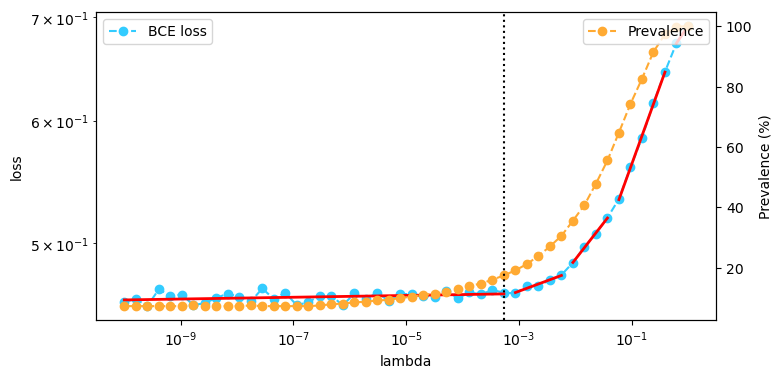

In [34]:
lmbd_range = np.exp(result_dict['log_lambda_range'])
loss_recode = result_dict['loss_history']
pvl_recode = result_dict['Prevalence']
pvl_recode = pvl_recode * 100

xs = np.log(lmbd_range); ys = np.log(loss_recode)
fig, ax1 = plt.subplots(figsize = (8, 4))
ax2 = ax1.twinx()
dys = np.gradient(ys, xs)


from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

k = 5
rgr = DecisionTreeRegressor(max_leaf_nodes = k).fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
ys_sl = np.ones(len(xs)) * np.nan
for y in np.unique(dys_dt):
    msk = dys_dt == y
    lin_reg = LinearRegression()
    lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
    ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
    ax1.plot(np.exp([xs[msk][0], xs[msk][-1]]), np.exp([ys_sl[msk][0], ys_sl[msk][-1]]), color='r', zorder=5, linewidth = 2)


segth = []; count = 0
for i in range(len(dys_dt)):
    if dys_dt[i] not in segth:
        segth.append(dys_dt[i])
        count += 1
    if count == 1:
        selected_lambda = xs[i]

ax1.errorbar(lmbd_range, loss_recode, marker='o', c='#33CCFF', linestyle='--', label ='BCE loss'); ax1.legend(loc='upper left')
ax2.errorbar(lmbd_range, pvl_recode, marker='o', c='#FFAA33', linestyle='--', label='Prevalence', zorder=1); ax2.legend(loc='upper right')
ax1.set(xscale="log"); ax1.set(yscale="log")
ax1.set_xlabel("lambda"); ax1.set_ylabel("loss"); ax2.set_ylabel("Prevalence (%)")
selected_lambda = np.exp(selected_lambda); plt.axvline(x=selected_lambda, color = 'black', linestyle=':')
plt.show()

In [35]:
selected_lambda

0.0005428675439323858

In [37]:
from ADlasso2 import AD2_w_utils as ad
importlib.reload(ad)


<module 'ADlasso2.AD2_w_utils' from '/Users/evanli/Documents/EvanPys/Progress/ADlasso2/AD2_w_utils.py'>

In [44]:
# k: Decide n_segments to divide
opt_lmbd, fig = ad.lambda_decision(result_dict, k=5)
opt_lmbd

NameError: name 'result_dict' is not defined

## Find marker genes with optimal lambda

In [9]:
opt_lmbd = 0.0005428675439323858
opt_lmbd

0.0005428675439323858

In [10]:
pvl = ad.get_prevalence(data.X, alpha_indices)
opt_res = ad.ADlasso2(lmbd=opt_lmbd, echo=True)
opt_res.fit(data.X, alpha_label, pvl)

Getting prevalance
QWL-QN convergence
QWL-QN convergence
minimum epoch =  2 ; minimum lost =  0.46481844782829285 ; diff weight =  1.687087569735013e-05


In [11]:
print('median of selected prevalence :',np.median([pvl[i]  for i, w in enumerate(opt_res.feature_set) if w != 0]))
print('total selected feature :',np.sum(opt_res.feature_set))

median of selected prevalence : 0.17463617463617465
total selected feature : 8608


In [12]:
opt_res.loss_

0.46481844782829285

In [40]:
# Export selection results (/LmbdTuning/tuning_alpha)
opt_res.writeList(outpath='./alpha_features.txt', featureNameList=data.var_names)


## Selection profile

In [13]:
import numpy as np
import random

def train_test_split_evan(X, y, test_size=0.2):
    if isinstance(y, list):
        y = np.array(y)
    train_test_index = [True] * int(X.shape[0] * (1 - test_size)) + [False] * (X.shape[0] - int(X.shape[0] * (1 - test_size)))
    random.shuffle(train_test_index)
    train_index = np.where(train_test_index)[0]
    test_index = np.where(np.logical_not(train_test_index))[0]
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]

    return train_X, test_X, train_y, test_y

In [14]:
train_X, test_X, train_y, test_y = train_test_split_evan(data.X, alpha_label)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2956, 27998) (740, 27998) (2956,) (740,)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

LR = LogisticRegression()
SVM = SVC(probability = True)
RF = RandomForestClassifier()

In [16]:
# Logistic Regression
perf = ad.evaluation(train_X, train_y, test_X, test_y, opt_res, LR)
print('LogisticRegression: ', perf)

LogisticRegression:  {'AUC': 0.9858302089384099, 'AUPR': 0.9509680236370471, 'MCC': 0.8602169933810858}


In [74]:
# SVM
pref = ad.evaluation(train_X, train_y, test_X, test_y, opt_res, SVM)
print("SVM: ", pref)

In [17]:
# Random forest
perf = ad.evaluation(train_X, train_y, test_X, test_y, opt_res, RF)
print('Random forest : ', perf)

Random forest :  {'AUC': 0.9830754607382373, 'AUPR': 0.9029749848987887, 'MCC': 0.7202631103960822}


In [20]:
data.var_names

Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Rgs20', 'Npbwr1', '4732440D04Rik',
       ...
       'Gm28406', 'Gm29436', 'Gm28407', 'Gm29393', 'Gm21294', 'Gm28672',
       'Gm28670', 'Gm29504', 'Gm20837', 'Erdr1'],
      dtype='object', name='index', length=27998)

In [32]:
os.chdir('./LmbdTuning/tuning alpha/')
!pwd

/Users/evanli/Documents/EvanPys/Progress/LmbdTuning/tuning alpha


In [33]:
Prop = ad.featureProperty(data.X, alpha_label, opt_res)
Prop['featureID'] = data.var_names

# Prop.to_csv('alpha_feature_property.csv', index=False)
Prop

# prevalence_0: prevalence of the class "0"
# prevalence_1: prevalence of the class "1"

Getting prevalance
Getting prevalance
Getting prevalance


,meanAbundance,Variance,select,prevalence,prevalence_0,prevalence_1,featureID
0,0.001125,0.000779,No selected,0.001623,0.001244,0.004158,Xkr4
1,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Gm37381
2,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Rp1
3,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Rp1-1
4,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Sox17
...,...,...,...,...,...,...,...
27993,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Gm28672
27994,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Gm28670
27995,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Gm29504
27996,0.000000,0.000000,No selected,0.000000,0.000000,0.000000,Gm20837


[None]

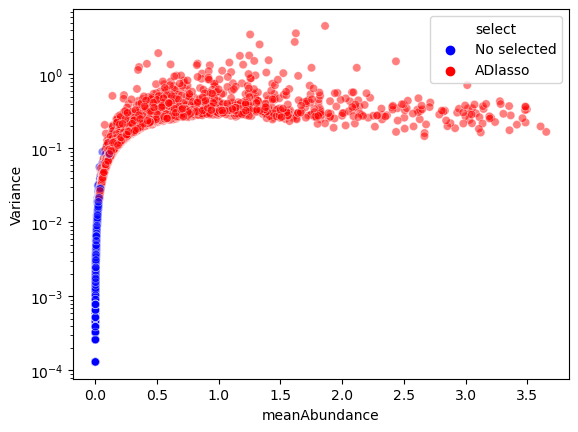

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
g = sns.scatterplot(x="meanAbundance", y="Variance", hue="select", palette=['b', 'r'], alpha = 0.5, data=Prop)
g.set(yscale="log")

[None]

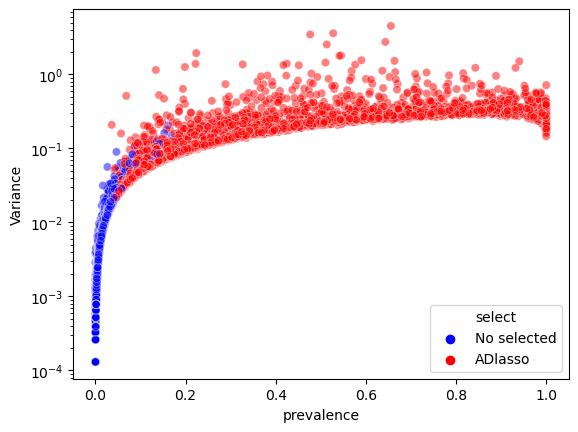

In [27]:
g =sns.scatterplot(x="prevalence", y="Variance", hue="select", palette=['b', 'r'], alpha = 0.5, data=Prop)
g.set(yscale="log")

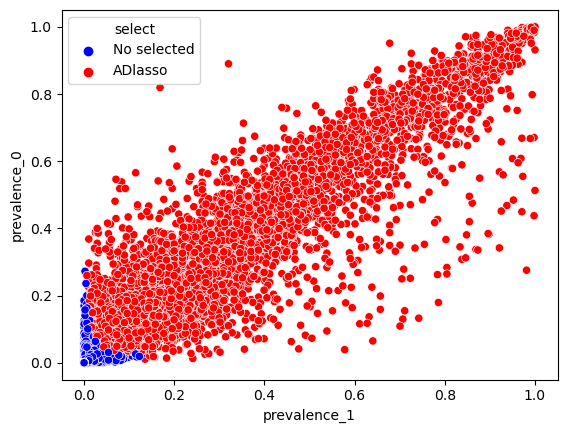

In [29]:
# X-axis: Prevalence of alpha cells (class = 1)
# Y-axis: Prevalence of non-alpha cells (class = 0)
g =sns.scatterplot(x="prevalence_1", y="prevalence_0", hue="select", palette=['b', 'r'], data=Prop)